### Задачи к Лекции 3

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("D://шкИла//третекурс//6 сем//обработка речи//mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,True,False,False,True,False,False,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,False,False,True,True,False,False,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,False,False,True,True,False,False,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,True,False,False,True,False,False,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,True,False,False,True,False,False,0


In [10]:
#!pip install numpy==1.22.4

Defaulting to user installation because normal site-packages is not writeable


## Классы в Python

Нередко, возникает необходимость создания объектов с каким-нибудь внутренним поведением и состоянием. Примерами таких объектов являются классификаторы sklearn, массивы numpy и много другое. Такой объект можно объявить с помощью ключевого слова **class**

```python
class SomeObject:
    def __init__(self, depth):
        self.a = depth
        self.target = None
        
    def fit(self, data, target):
        self.target = data
        # magic
        return 
    
    def predict(self, data):
        return self.target    
```

После этого в коде можно будет создать экземпляр данного класса
```python
a = SomeObject(depth=5)
a.fit(data, target)
a.predict(data)
```

## Задачи

**1. В sklearn на данный момент отсутствует функционал для построения деревьев решений из категориальных данных, поэтому его нужно сделать самостоятельно и проверить его работу. Что нужно сделать:**

* __создать классификатор используя только pandas, numpy и scipy. Необходимо его сделать самому, используя исключительно только numpy, pandas и scipy (запрещено использовать sklearn и прочие библиотеки). Напоминаю, что для категориальных данных операция < или > не имеют смысла (использовать только != и ==). Гиперпараметром данного классификатора должна быть максимальная глубина дерева.__
* __Проверить работу данного классификатора на наборе ("gender", "cholesterol", "gluc").__
* __С помощью кросс-валидации найти оптимальную глубину этого дерева. Для вашего классификатора GridSearchCV не подойдет, придется это сделать также самостоятельно.__
* __Нарисовать полученное дерево (я должен понять, как и откуда вы его нарисовали).__

Алгоритм работы классификатора:
 1. Перебираем все возможные признаки и смотрим либо неопределенность Джини, либо прирост информации. Это даст критерий разбиения в виде "признак == значение"
 2. Если выборка полученная при разбиении состоит из объектов одного класса (соответсвует нулевой энтропии), то данный лист просто возвращает значение этого класса.
 3. В противном случае, образуется новый узел и для него начинаем с пункта 1.
 4. Если достигли максимальной глубины, то вместа узла создаем лист, который возвращает самое вероятное значение.
 
__Замечание:__ в этой задаче не нужно использовать onehot-кодирование.

In [12]:
import numpy as np
import pandas as pd
from collections import Counter

#класс узла
class DecisionNode:
    def __init__(self, feature=None, value=None, left=None, right=None, *, result=None):
        self.feature = feature      # признак для разбиения
        self.value = value          # значение признака
        self.left = left            # поддерево слева (если feature == value)
        self.right = right          # поддерево справа (feature != value)
        self.result = result        # если это лист, то здесь хранится предсказание (0 или 1)
        
#то есть например для cholecterol||1
#example = DecisionNode(
#    feature="cholesterol",
#    value=1,
#    left=DecisionNode(result=0),
#    right=DecisionNode(result=1)
#)

In [3]:
#!pip install --upgrade numexpr bottleneck

Defaulting to user installation because normal site-packages is not writeable
  Using cached numexpr-2.10.2-cp39-cp39-win_amd64.whl (144 kB)
  Using cached bottleneck-1.5.0-cp39-cp39-win_amd64.whl (112 kB)


In [13]:
def entropy(y):
    counts = np.bincount(y)
    probs = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def information_gain(y, y_left, y_right):
    H = entropy(y)
    H_left = entropy(y_left)
    H_right = entropy(y_right)
    return H - (len(y_left)/len(y)) * H_left - (len(y_right)/len(y)) * H_right

In [14]:
class DecisionTreeCategorical:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        #если все одного класса или достигли максимальной глубины
        if len(set(y)) == 1 or depth == self.max_depth:
            return DecisionNode(result=Counter(y).most_common(1)[0][0])

        best_gain = 0
        best_feature = None
        best_value = None
        best_split = None

        for feature in X.columns:
            for value in X[feature].unique():
                mask = X[feature] == value
                y_left, y_right = y[mask], y[~mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain(y, y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_value = value
                    best_split = mask

        if best_gain == 0:
            return DecisionNode(result=Counter(y).most_common(1)[0][0])

        left = self._build_tree(X[best_split], y[best_split], depth + 1)
        right = self._build_tree(X[~best_split], y[~best_split], depth + 1)

        return DecisionNode(feature=best_feature, value=best_value, left=left, right=right)

    def predict_one(self, x, node):
        if node.result is not None:
            return node.result
        if x[node.feature] == node.value:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return X.apply(lambda row: self.predict_one(row, self.root), axis=1)

In [15]:
features = ['gender', 'cholesterol', 'gluc']
X = df[features]
y = df['cardio']

#train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeCategorical(max_depth=3)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5893809523809523
Confusion Matrix:
 [[8462 1999]
 [6624 3915]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.81      0.66     10461
           1       0.66      0.37      0.48     10539

    accuracy                           0.59     21000
   macro avg       0.61      0.59      0.57     21000
weighted avg       0.61      0.59      0.57     21000



In [17]:
def print_tree(node, indent=""):
    if node.result is not None:
        print(indent + "Predict:", node.result)
    else:
        print(indent + f"{node.feature} == {node.value}?")
        print(indent + '--> True:')
        print_tree(node.left, indent + "  ")
        print(indent + '--> False:')
        print_tree(node.right, indent + "  ")

# пример
print_tree(tree.root)

cholesterol == 1?
--> True:
  gluc == 2?
  --> True:
    gender == 1?
    --> True:
      Predict: 1
    --> False:
      Predict: 1
  --> False:
    gender == 1?
    --> True:
      Predict: 0
    --> False:
      Predict: 0
--> False:
  cholesterol == 3?
  --> True:
    gluc == 3?
    --> True:
      Predict: 1
    --> False:
      Predict: 1
  --> False:
    gender == 2?
    --> True:
      Predict: 1
    --> False:
      Predict: 1


In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(X, y, max_depth, n_splits=5): #разделение на 5 частей для кросс валидации
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] #возврат индексов выборок чтобы потом по ним взять др данные

        #обучение модели
        tree = DecisionTreeCategorical(max_depth=max_depth)
        tree.fit(X_train, y_train)

        # Предсказание и оценка точности
        y_pred = tree.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return np.mean(accuracies)

#подбор оптимальной глубины
depth_range = range(1, 11)  #проверка от 1 до 10
best_depth = None
best_accuracy = 0

for depth in depth_range:
    accuracy = cross_validate(X, y, max_depth=depth)
    print(f"Depth {depth}: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"\nBest depth: {best_depth} with accuracy: {best_accuracy:.4f}")

Depth 1: 0.5893
Depth 2: 0.5918
Depth 3: 0.5918
Depth 4: 0.5918
Depth 5: 0.5918
Depth 6: 0.5918
Depth 7: 0.5918
Depth 8: 0.5918
Depth 9: 0.5918
Depth 10: 0.5918

Best depth: 2 with accuracy: 0.5918


In [19]:
#обучение на оптимальной глубине
final_tree = DecisionTreeCategorical(max_depth=2)
final_tree.fit(X, y)

In [21]:
def print_tree(node, indent=''):
    # Если это лист
    if node.result is not None:
        print(indent + f"Predict: {node.result}")
    else:
        print(indent + f"if {node.feature} == {node.value}:")
        print_tree(node.left, indent + "    ")
        print(indent + f"else:")
        print_tree(node.right, indent + "    ")

# Вывод дерева
print_tree(final_tree.root)

if cholesterol == 1:
    if gluc == 2:
        Predict: 1
    else:
        Predict: 0
else:
    if cholesterol == 3:
        Predict: 1
    else:
        Predict: 1


In [22]:
#УРА
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Обучение
final_tree = DecisionTreeCategorical(max_depth=2)
final_tree.fit(X_train, y_train)

In [23]:
y_pred = final_tree.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", round(acc, 4))
print("\nClassification report:\n", report)

Accuracy: 0.5903

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.81      0.66     10506
           1       0.66      0.37      0.48     10494

    accuracy                           0.59     21000
   macro avg       0.61      0.59      0.57     21000
weighted avg       0.61      0.59      0.57     21000



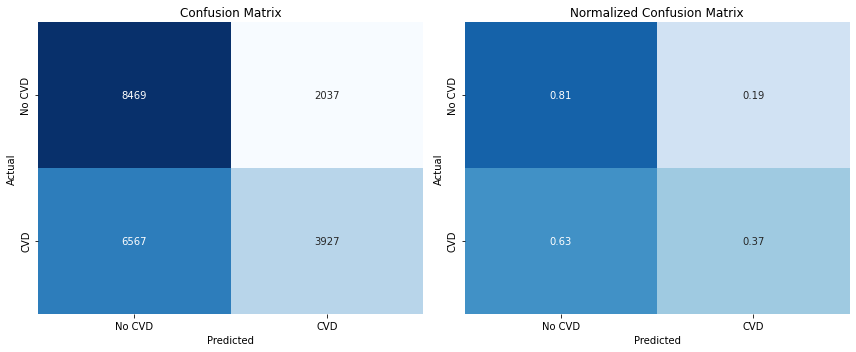

In [24]:
# Матрица неточностей
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No CVD', 'CVD'], 
            yticklabels=['No CVD', 'CVD'],
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No CVD', 'CVD'], 
            yticklabels=['No CVD', 'CVD'],
            cbar=False, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

**Комментарии:** Ваши комментарии здесь.